In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import random

# Load data

In [2]:
def get_unique_video_names(images_path):
    video_names = []
    file_list = os.listdir(images_path)
    for file in file_list :
        if file.endswith('.jpg'):
            file = file.split('_')
            video_name = f'{file[0]}_{file[1]}_{file[2]}_{file[3]}'
            video_names.append(video_name)
    unique_video_names = set(video_names)
    return list(unique_video_names)

In [3]:
def load_data():
    classes = {'pushups':0, 'squats':1, 'cleanjerk':2, 'jumpingjack':3,'lunges':4,'pullups':5} 
    imgs = []
    labels = []
    data_path = 'black_frames'
    for (cl, i) in classes.items(): 
        images_path = os.path.join(data_path, cl)
        files_list = os.listdir(images_path)
        unique_video_names = get_unique_video_names(images_path)
        random.shuffle(unique_video_names)
        unique_video_names = unique_video_names[0:50]
        for name in unique_video_names:
            total_frames = [file for file in files_list if file.startswith(name)]
            upper_range = len(total_frames)
            step = int(upper_range/10)
            video_sequence = []
            for index in range(0,upper_range,step):
                img = f"{name}_black{index}.jpg"
                path = os.path.join(data_path, cl, img)
                image = Image.open(path)
                image = image.resize((32,24))
                video_sequence.append(np.array(image))
                
            imgs.append(video_sequence[0:10])
            labels.append(i)
    return labels, imgs

In [4]:
%%time
labels, imgs =load_data()

CPU times: user 7.5 s, sys: 1.33 s, total: 8.82 s
Wall time: 14.8 s


In [5]:
X = np.array(imgs)
num_classes = len(set(labels))
y = to_categorical(labels, num_classes)

In [6]:
p = np.random.permutation(len(X))
X, y = X[p], y[p]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [8]:
X_train.shape

(210, 10, 24, 32, 3)

# Model convLSTM

In [9]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), data_format='channels_last', return_sequences = False, input_shape = (10, 24, 32, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(6, activation = "softmax"))

opt = SGD(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'Precision'])

2021-09-03 13:27:09.049679: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 22, 30, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 22, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 42240)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               10813696  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 10,969,862
Trainable params: 10,969,862
Non-trainable params: 0
____________________________________________

In [11]:
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

history = model.fit(x = X_train, y = y_train, epochs=40, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/40


2021-09-03 13:27:46.988132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


21/21 [==============================] - 34s 2s/step - loss: 1.8007 - accuracy: 0.2024 - precision: 0.0000e+00 - val_loss: 1.6541 - val_accuracy: 0.3095 - val_precision: 0.0000e+00
Epoch 2/40
21/21 [==============================] - 29s 1s/step - loss: 1.5188 - accuracy: 0.4107 - precision: 0.0000e+00 - val_loss: 1.5327 - val_accuracy: 0.5714 - val_precision: 0.0000e+00
Epoch 3/40
21/21 [==============================] - 29s 1s/step - loss: 1.3094 - accuracy: 0.6310 - precision: 1.0000 - val_loss: 1.4162 - val_accuracy: 0.6905 - val_precision: 0.0000e+00
Epoch 4/40
21/21 [==============================] - 28s 1s/step - loss: 1.1050 - accuracy: 0.8036 - precision: 1.0000 - val_loss: 1.3290 - val_accuracy: 0.7143 - val_precision: 0.0000e+00
Epoch 5/40
21/21 [==============================] - 30s 1s/step - loss: 0.9490 - accuracy: 0.8452 - precision: 1.0000 - val_loss: 1.2490 - val_accuracy: 0.7381 - val_precision: 1.0000
Epoch 6/40
21/21 [==============================] - 30s 1s/step - l

In [12]:
# evaluate
res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

#print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')

3/3 [==============================] - 4s 1s/step - loss: 0.5263 - accuracy: 0.8333 - precision: 0.9444
test_accuracy_vgg = 83.0 %
Chance level: 16.7%


In [13]:
# learning curves
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

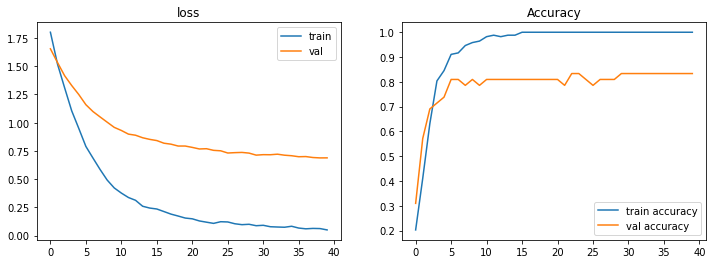

In [14]:
plot_history(history, title='ConvLSTM')

In [19]:
def load_test_data_from_folder(folder_filepath, name="test"):
    imgs = []
    video_sequence = []
    upper_range = len(os.listdir(folder_filepath))
    step = int(upper_range/10)
    for index in range(0,upper_range,step):
        img = f"{name}_black{index}.jpg"
        path = os.path.join(folder_filepath, img)
        image = Image.open(path)
        image = image.resize((32,24))
        video_sequence.append(np.array(image))
                
    imgs.append(video_sequence[0:10])

    return imgs

In [20]:
test = np.array(load_test_data_from_folder('test', 'test3'))

In [21]:
test.shape

(1, 10, 24, 32, 3)

In [40]:
classes = {0:'Push Up', 1:'Squat', 2:'Clean&Jerk', 3:'Jumping Jack', 4:'Lunge', 5:'Pull Up'} 
prediction_array = model.predict(test)[0]
prediction = np.where(prediction_array == prediction_array.max())[0][0]
print(f"You are performing a {classes[prediction]}")

You are performing a Lunge


In [32]:
y_pred = model.predict(X_test)

In [41]:
pred = []
real = []
for i in range(0,90):
    prediction_array = y_pred[i]
    real_array = y_test[i]
    pred.append(classes[np.where(prediction_array == prediction_array.max())[0][0]])
    real.append(classes[np.where(real_array == real_array.max())[0][0]])

In [42]:
results = pd.DataFrame(
{'real': real,
'prediction': pred}
)

In [45]:
results['outcome']=results['real']==results['prediction']

In [47]:
results[results['outcome']==False]

,real,prediction,outcome
11,Jumping Jack,Clean&Jerk,False
14,Clean&Jerk,Squat,False
16,Jumping Jack,Clean&Jerk,False
30,Squat,Push Up,False
35,Jumping Jack,Lunge,False
36,Lunge,Push Up,False
44,Jumping Jack,Lunge,False
57,Lunge,Push Up,False
60,Clean&Jerk,Pull Up,False
63,Jumping Jack,Lunge,False


In [48]:
set(labels)

{0, 1, 2, 3, 4, 5}